In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as ols
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.eval_measures import rmse
from sklearn.preprocessing import scale
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.preprocessing import scale, minmax_scale

%matplotlib inline

In [118]:
ds_boston = pd.read_csv("./BOSTON_HOUSING.csv", engine='python')
ds_boston.head()

,MEDV,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,24.000000,0.00632,18.0,2.31,0,0.538,6.575,65.199997,4.0900,1,296,15.300000,396.899994,4.98
1,21.600000,0.02731,0.0,7.07,0,0.469,6.421,78.900002,4.9671,2,242,17.799999,396.899994,9.14
2,34.700001,0.02729,0.0,7.07,0,0.469,7.185,61.099998,4.9671,2,242,17.799999,392.829987,4.03
3,33.400002,0.03237,0.0,2.18,0,0.458,6.998,45.799999,6.0622,3,222,18.700001,394.630005,2.94
4,36.200001,0.06905,0.0,2.18,0,0.458,7.147,54.200001,6.0622,3,222,18.700001,396.899994,5.33


In [177]:
print("결측치 확인")
ds_boston.isnull().sum()

결측치 확인


MEDV       0
CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
dtype: int64

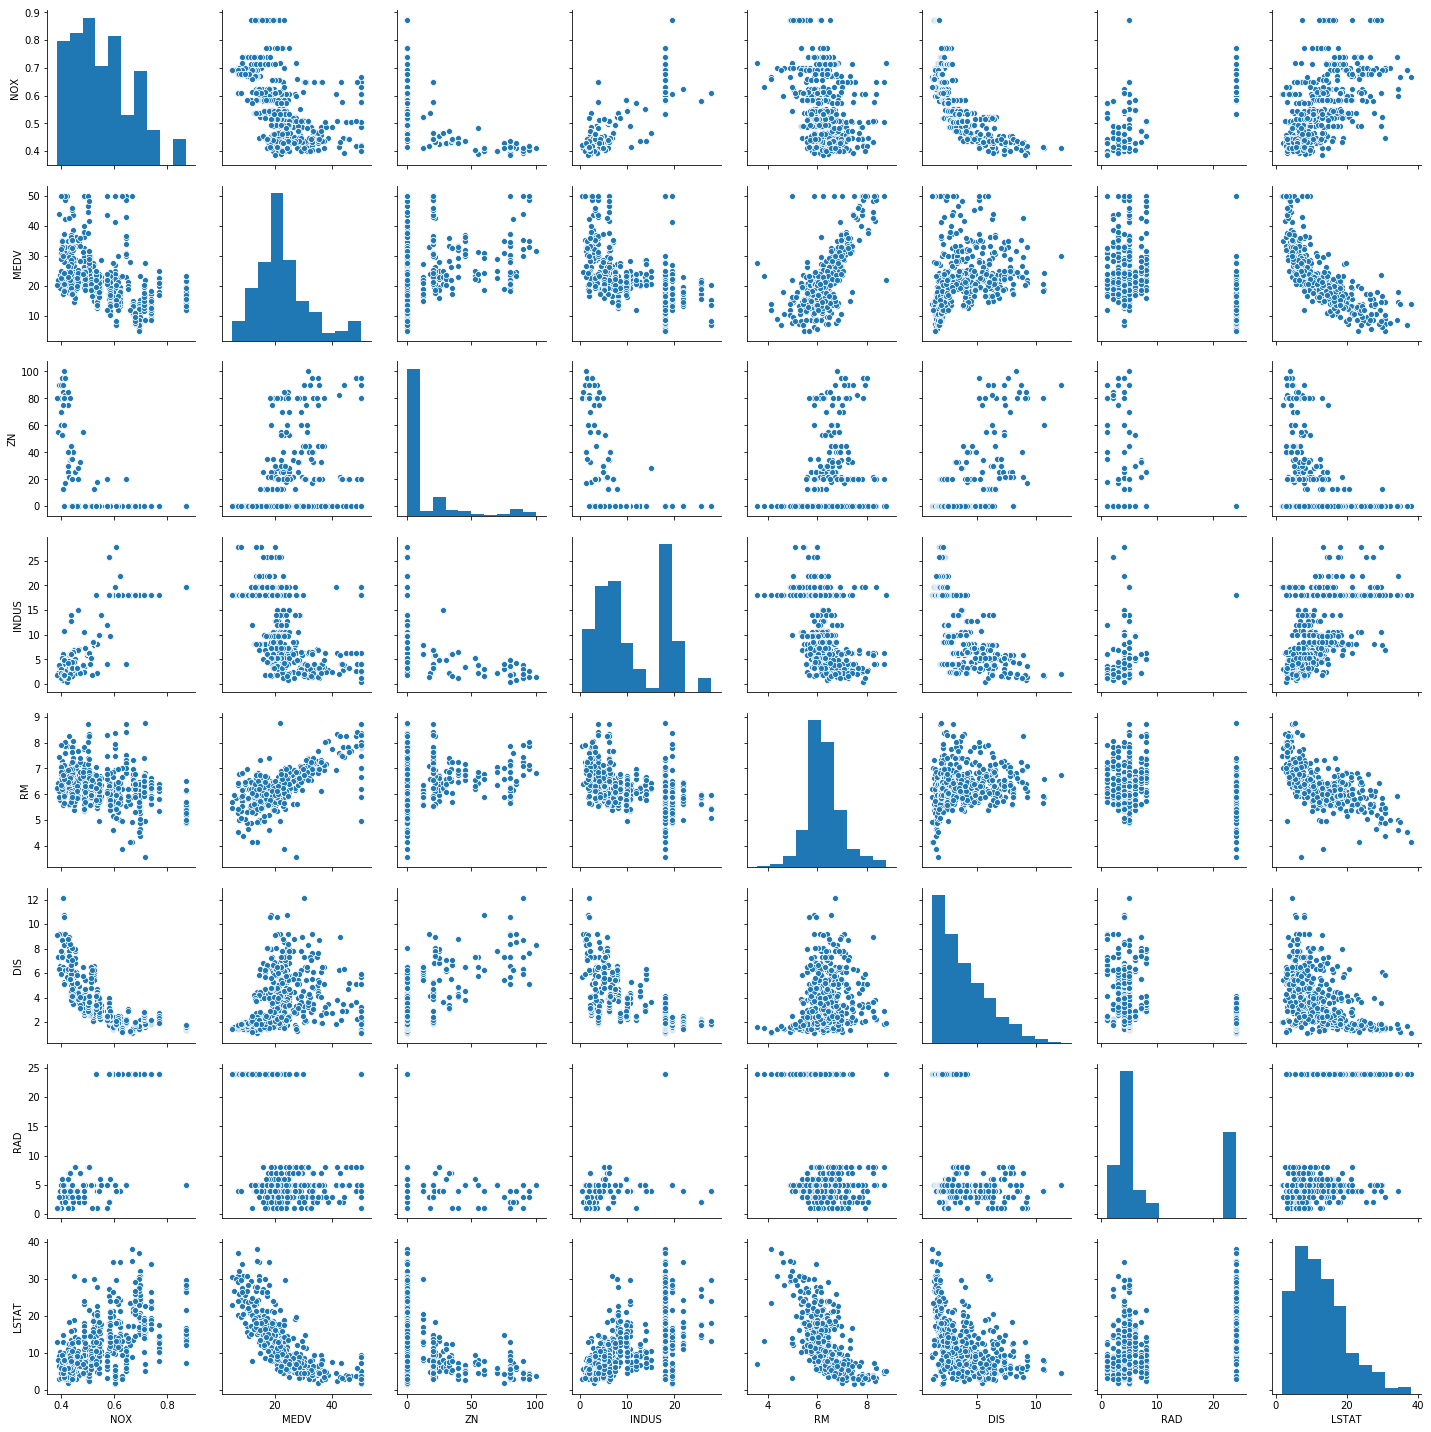

In [243]:
df_boston = ds_boston[["NOX","MEDV","ZN","INDUS","RM","DIS","RAD","LSTAT"]]
sns.pairplot(df_boston)

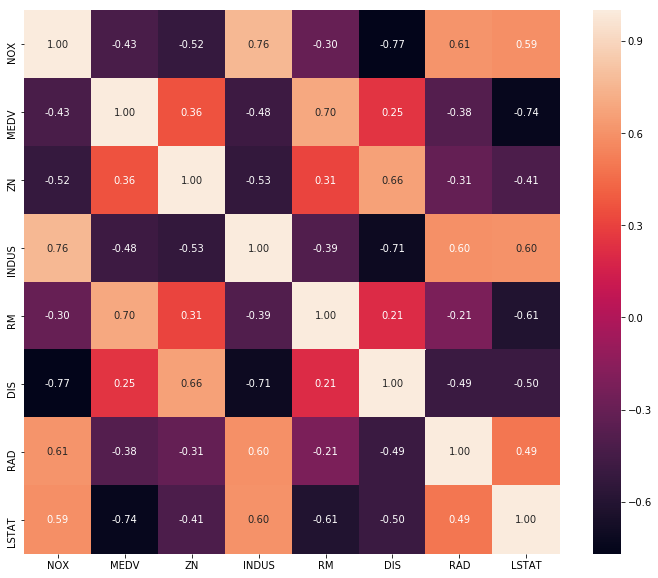

In [244]:
plt.figure(figsize=(12,10))
sns.heatmap(df_boston.corr(),annot=True, fmt='.2f')

/home/pirl/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


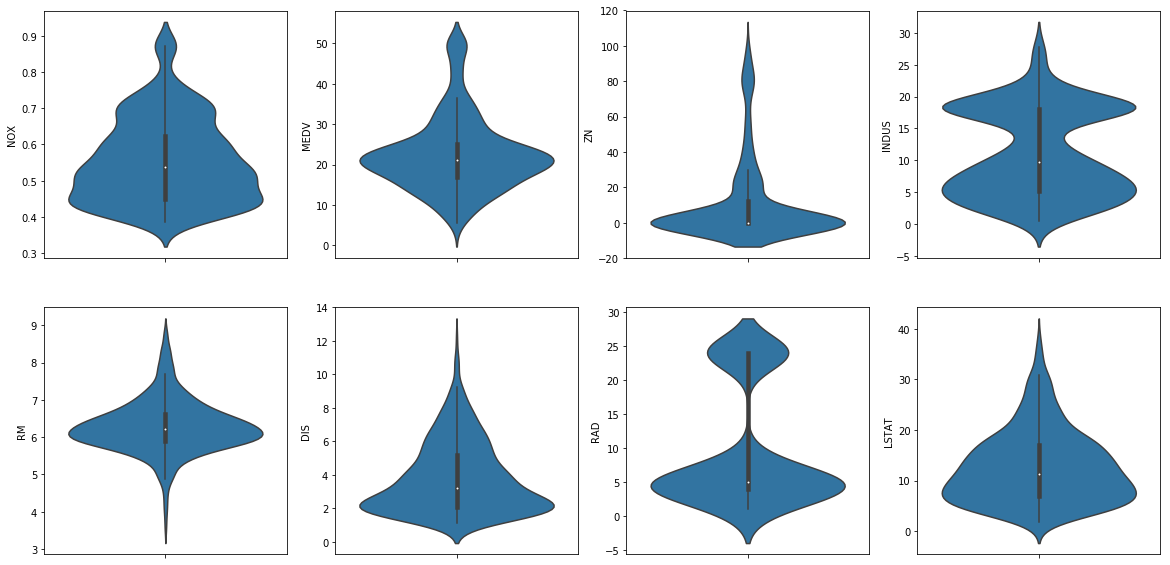

In [245]:
draw_multivarient_plot(df_boston,2,4,"violin")

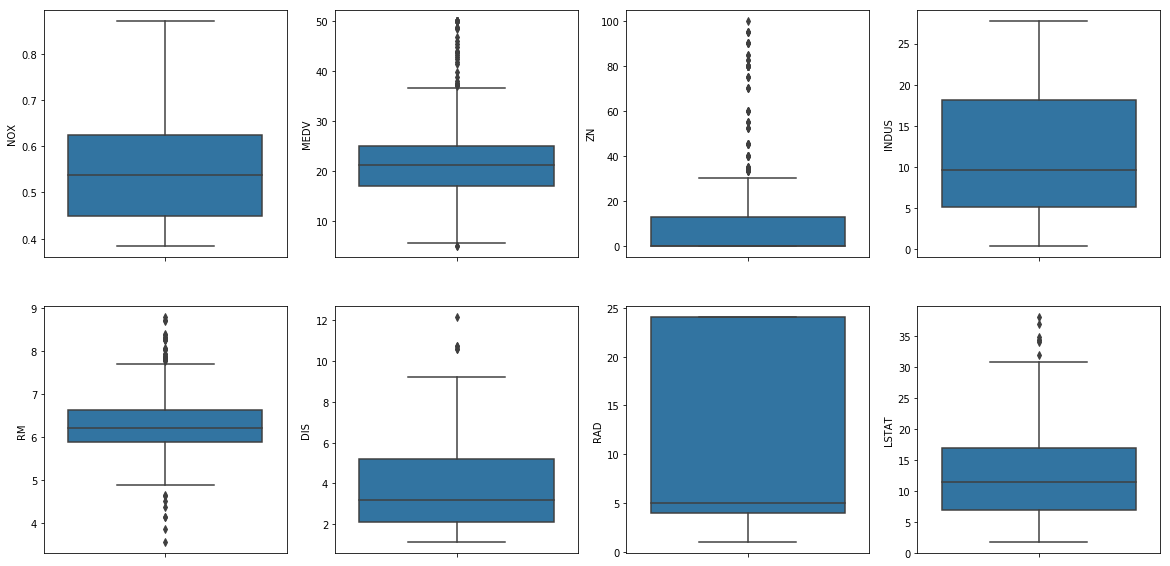

In [246]:
draw_multivarient_plot(df_boston,2,4,"box")

In [259]:
for k, v in df_boston.items():
        q1 = v.quantile(0.25)
        q3 = v.quantile(0.75)
        irq = q3 - q1
        v_col = v[(v <= q1 - 1.5 * irq) | (v >= q3 + 1.5 * irq)]
        perc = np.shape(v_col)[0] * 100.0 / np.shape(ds_boston)[0]
        print("%s 이상치 = %.2f%%" % (k, perc))

NOX 이상치 = 0.00%
MEDV 이상치 = 7.91%
ZN 이상치 = 13.44%
INDUS 이상치 = 0.00%
RM 이상치 = 5.93%
DIS 이상치 = 0.99%
RAD 이상치 = 0.00%
LSTAT 이상치 = 1.38%


In [261]:
df_boston["ZN"].describe()

count    506.000000
mean      11.363636
std       23.322453
min        0.000000
25%        0.000000
50%        0.000000
75%       12.500000
max      100.000000
Name: ZN, dtype: float64

In [271]:
print(df_boston["ZN"].sort_values(ascending=False).head(40))
print(df_boston["ZN"].sort_values(ascending=False).tail(40))

57     100.0
204     95.0
199     95.0
200     95.0
203     95.0
283     90.0
353     90.0
55      90.0
284     90.0
256     90.0
347     85.0
56      85.0
201     82.5
202     82.5
197     80.0
198     80.0
255     80.0
254     80.0
355     80.0
195     80.0
286     80.0
290     80.0
291     80.0
292     80.0
348     80.0
196     80.0
354     80.0
65      80.0
66      80.0
39      75.0
54      75.0
40      75.0
298     70.0
300     70.0
299     70.0
351     60.0
352     60.0
194     60.0
193     60.0
343     55.0
Name: ZN, dtype: float64
429    0.0
428    0.0
427    0.0
426    0.0
424    0.0
436    0.0
423    0.0
422    0.0
421    0.0
420    0.0
419    0.0
418    0.0
417    0.0
416    0.0
415    0.0
435    0.0
437    0.0
458    0.0
448    0.0
457    0.0
456    0.0
455    0.0
454    0.0
453    0.0
452    0.0
451    0.0
450    0.0
449    0.0
447    0.0
438    0.0
504    0.0
446    0.0
445    0.0
444    0.0
443    0.0
442    0.0
441    0.0
440    0.0
439    0.0
505    0.0
Name: ZN, dtype

In [247]:
df_boston_y = df_boston["NOX"]
df_boston_x = df_boston.drop("NOX", axis=1, inplace=False)
df_vif = pd.DataFrame()
df_vif["variable"] = df_boston_x.columns
df_vif["vif"] = [variance_inflation_factor(df_boston_x.values,i) for i in range(df_boston_x.shape[1])]
df_vif.sort_values("vif", inplace=True)
df_vif.round(3)

,variable,vif
1,ZN,2.345
5,RAD,3.738
6,LSTAT,8.721
2,INDUS,9.014
4,DIS,9.926
0,MEDV,21.356
3,RM,60.458


In [252]:
sm.add_constant(df_boston_x).head()

,const,MEDV,ZN,INDUS,RM,DIS,RAD,LSTAT
0,1.0,24.000000,18.0,2.31,6.575,4.0900,1,4.98
1,1.0,21.600000,0.0,7.07,6.421,4.9671,2,9.14
2,1.0,34.700001,0.0,7.07,7.185,4.9671,2,4.03
3,1.0,33.400002,0.0,2.18,6.998,6.0622,3,2.94
4,1.0,36.200001,0.0,2.18,7.147,6.0622,3,5.33


In [255]:
df_boston_x_const = sm.add_constant(df_boston_x.drop(["MEDV","RM"],axis=1,inplace=False))
reg_multi_model = sm.OLS(df_boston_y, df_boston_x_const)
reg_multi_res = reg_multi_model.fit()
print(reg_multi_res.summary())

                            OLS Regression Results                            
Dep. Variable:                    NOX   R-squared:                       0.722
Model:                            OLS   Adj. R-squared:                  0.719
Method:                 Least Squares   F-statistic:                     259.6
Date:                Thu, 31 Jan 2019   Prob (F-statistic):          2.02e-136
Time:                        23:10:22   Log-Likelihood:                 696.87
No. Observations:                 506   AIC:                            -1382.
Df Residuals:                     500   BIC:                            -1356.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5405      0.013     40.597      0.0

In [289]:
df_boston_x_const = sm.add_constant(df_boston_x.drop(["MEDV","RM","ZN"],axis=1,inplace=False))
reg_multi_model = sm.OLS(df_boston_y, df_boston_x_const)
reg_multi_res = reg_multi_model.fit()
print(reg_multi_res.summary())

                            OLS Regression Results                            
Dep. Variable:                    NOX   R-squared:                       0.721
Model:                            OLS   Adj. R-squared:                  0.719
Method:                 Least Squares   F-statistic:                     323.9
Date:                Fri, 01 Feb 2019   Prob (F-statistic):          2.10e-137
Time:                        01:23:03   Log-Likelihood:                 696.16
No. Observations:                 506   AIC:                            -1382.
Df Residuals:                     501   BIC:                            -1361.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5393      0.013     40.611      0.0

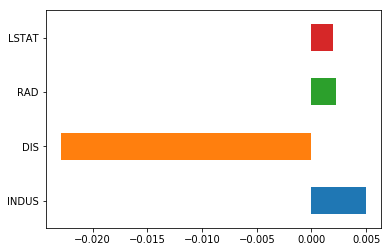

In [290]:
df_reg_coef = pd.DataFrame({"Coef":reg_multi_res.params.values[1:]},index=reg_multi_model.exog_names[1:])
df_reg_coef.plot.barh(y="Coef",legend=False)
# df_boston_x_scaled = scale(df_boston_x_const)
# df_boston_x_scaled = sm.add_constant(df_boston_x_const)
# reg_scaled_res = sm.OLS(df_boston_y,df_boston_x_scaled)
# reg_scaled_res = reg_scaled_res.fit()
# df_reg_scaled_coef = pd.DataFrame({"Coef": reg_scaled_res.params.values[1:]},index=reg)

/home/pirl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by the scale function.
  """Entry point for launching an IPython kernel.


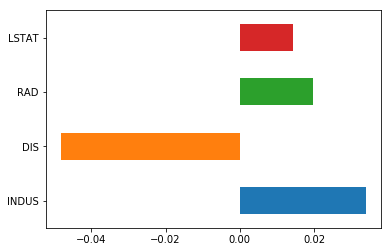

In [292]:
df_boston_x_scaled = scale(df_boston_x_const)
# df_boston_x_scaled = sm.add_constant(df_boston_x_scaled)
reg_scaled_model = sm.OLS(df_boston_y,df_boston_x_scaled)
reg_scaled_res = reg_scaled_model.fit()
df_reg_scaled_coef = pd.DataFrame({"Coef": reg_scaled_res.params.values[1:]},index=reg_multi_model.exog_names[1:])
df_reg_scaled_coef.plot.barh(y="Coef",legend=False)
# reg_scaled_model.exog_names[2:]
# reg_scaled_res.params.values
# df_boston_x_const.

(506,)

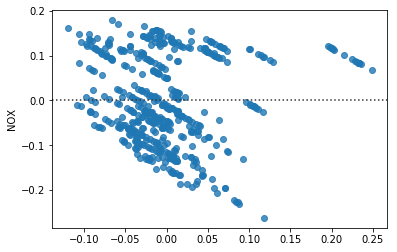

In [311]:
obs = reg_multi_res.resid.values
# z = (obs-np.mean(obs))/np.std(obs)
sns.residplot(obs,df_boston_y)
# stats.probplot(df_boston_x,df_boston_y)
obs.shape

((array([-2.99573567e+00, -2.71411028e+00, -2.55577619e+00, -2.44351800e+00,
         -2.35556494e+00, -2.28276382e+00, -2.22036495e+00, -2.16557440e+00,
         -2.11660431e+00, -2.07223893e+00, -2.03161265e+00, -1.99408648e+00,
         -1.95917475e+00, -1.92649942e+00, -1.89576017e+00, -1.86671438e+00,
         -1.83916307e+00, -1.81294098e+00, -1.78790928e+00, -1.76395019e+00,
         -1.74096288e+00, -1.71886034e+00, -1.69756695e+00, -1.67701655e+00,
         -1.65715093e+00, -1.63791855e+00, -1.61927361e+00, -1.60117517e+00,
         -1.58358651e+00, -1.56647453e+00, -1.54980933e+00, -1.53356377e+00,
         -1.51771316e+00, -1.50223493e+00, -1.48710847e+00, -1.47231481e+00,
         -1.45783653e+00, -1.44365756e+00, -1.42976302e+00, -1.41613915e+00,
         -1.40277318e+00, -1.38965322e+00, -1.37676820e+00, -1.36410778e+00,
         -1.35166231e+00, -1.33942275e+00, -1.32738062e+00, -1.31552796e+00,
         -1.30385728e+00, -1.29236155e+00, -1.28103411e+00, -1.26986869e+00,

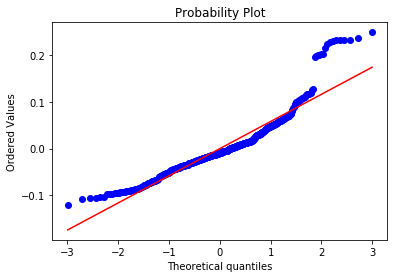

In [302]:
stats.probplot(obs, dist="norm",plot=plt)

In [149]:
def draw_multivarient_plot(dataset, rows, cols, plot_type):
    column_names=dataset.columns.values
    number_of_column=len(column_names)
    fig, axarr=plt.subplots(rows,cols, figsize=(5*cols,5*rows))

    counter=0
    for i in range(rows):
        for j in range(cols):
            if 'violin' in plot_type:
                sns.violinplot(y=column_names[counter],data=dataset, ax=axarr[i][j])
            elif 'box'in plot_type :
                sns.boxplot( y=column_names[counter],data=dataset, ax=axarr[i][j])
            elif 'point' in plot_type:
                sns.pointplot(y=column_names[counter],data=dataset, ax=axarr[i][j])
            elif 'bar' in plot_type:
                sns.barplot(y=column_names[counter],data=dataset, ax=axarr[i][j])

            counter+=1
            if counter==(number_of_column-1,):
                break